In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.datasets import make_regression
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.robust.robust_linear_model as rlm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel 
from collections import Counter
from sklearn import model_selection, naive_bayes, svm, metrics, feature_extraction
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.utils.fixes import loguniform
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn import model_selection, naive_bayes, metrics,feature_extraction
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.exceptions import NotFittedError
import joblib
import datetime
import warnings
from sklearn.pipeline import Pipeline
from numpy import argmax
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.ticker as mticker 
from matplotlib.ticker import ScalarFormatter 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, brier_score_loss, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import datetime
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [3]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [4]:
#Average time delta between transactions !not used in calculations
def list_diff(x_input):
    if len(x_input)<2:
        xdiff = 0
        delta_mean=0
    else:
        xdiff = [x_input[n]-x_input[n-1] for n in range(1,len(x_input))]
        delta_mean = np.mean(xdiff)
    return delta_mean
    
#Delta before last transaction !not used in calculations
def delta_last(x_input):
    if len(x_input)<2:
        delta_l=0
    else:
        delta_l = x_input[-1]-x_input[-2]
    return delta_l

def data_preprocessing(data):
    #number of transactions Orig !not used in calculations
    dict_count_sent = data['nameOrig'].value_counts()
    data['New_TotalOrig']= data['nameOrig'].map(dict_count_sent) 
    
    #number of transactions Dest !not used in calculations
    dict_count_get = data['nameDest'].value_counts()
    data['New_TotalDest']= data['nameDest'].map(dict_count_get)
    
    #average transaction Orig !not used in calculations
    trans_mean_orig = data.groupby("nameOrig")["amount"].aggregate(['mean'])
    dict_trans_mean_orig=trans_mean_orig.to_dict()
    value_dict_trans_mean_orig=dict_trans_mean_orig['mean']
    data['New_TotalMeanOrig']=data['nameOrig'].map(value_dict_trans_mean_orig)
    
    #average transaction Dest !not used in calculations
    trans_mean_dest = data.groupby("nameDest")["amount"].aggregate(['mean'])
    dict_trans_mean_dest=trans_mean_dest.to_dict()
    value_dict_trans_mean_dest=dict_trans_mean_dest['mean']
    data['New_TotalMeanDest']=data['nameDest'].map(value_dict_trans_mean_dest)
    
    #Amount of transactions with participation Orig !not used in calculations
    trans_sum_orig = data.groupby("nameOrig")["amount"].aggregate([sum])
    dict_trans_sum_orig=trans_sum_orig.to_dict()
    value_dict_trans_sum_orig=dict_trans_sum_orig['sum']
    data['New_TotalSumOrig']=data['nameOrig'].map(value_dict_trans_sum_orig)
    
    #Amount of transactions with participation Dest !not used in calculations
    trans_sum_dest = data.groupby("nameDest")["amount"].aggregate([sum])
    dict_trans_sum_dest=trans_sum_dest.to_dict()
    value_dict_trans_sum_dest=dict_trans_sum_dest['sum']
    data['New_TotalSumDest']=data['nameDest'].map(value_dict_trans_sum_dest)
    
    #type Orig ==first letter from nameOrig 
    data['New_TypeOrig']= data['nameOrig'].apply(lambda x: x[0])
    
    #type Dest ==first letter from nameDest
    data['New_TypeDest']= data['nameDest'].apply(lambda x: x[0])
    
    #Average time delta between transactions Orig !not used in calculations
    x_input = data.groupby('nameOrig')['step'].apply(list).reset_index(name='info')
    data = pd.merge(data, x_input, how='left', on='nameOrig')
    data['New_Delta_Time_Tr_Orig'] = data['info'].apply(lambda x: list_diff(x))
    #time to previous transaction Orig !not used in calculations
    data['New_Delta_Last_Tr_Orig']= data['info'].apply(lambda x: delta_last(x))
    
    #Average time delta between transactions Dest !not used in calculations
    x_input_dest = data.groupby('nameDest')['step'].apply(list).reset_index(name='info_2')
    data = pd.merge(data, x_input_dest, how='left', on='nameDest')
    data['New_Delta_Time_Tr_Dest'] = data['info_2'].apply(lambda x: list_diff(x) )
    #time to previous transaction Dest !not used in calculations
    data['New_Delta_Last_Tr_Dest']= data['info_2'].apply(lambda x: delta_last(x))
    
    #Removing extra columns
    data = data.drop(columns=['info','info_2'])
    
    #delete first letter Orig , Dest
    data['nameOrig']=data['nameOrig'].apply(lambda x: x[1:])
    data['nameDest']=data['nameDest'].apply(lambda x: x[1:])
    
    #!not used in calculations
    data['res_data']=pd.to_datetime(data['step'], unit='h', origin=pd.Timestamp('2000-01-01'))
    
    ### Select the date, days of the week, hours, month  !not used in calculations
    data['date'] = data.res_data.dt.date
    data['day_of_week'] = data.res_data.dt.dayofweek
    data['hour'] = data.res_data.dt.hour
    data['month'] = data.res_data.dt.month
    
    return data

In [5]:
data_f = data_preprocessing(data)

In [6]:
data_f.isnull().sum()

step                      0
type                      0
amount                    0
nameOrig                  0
oldbalanceOrg             0
newbalanceOrig            0
nameDest                  0
oldbalanceDest            0
newbalanceDest            0
isFraud                   0
isFlaggedFraud            0
New_TotalOrig             0
New_TotalDest             0
New_TotalMeanOrig         0
New_TotalMeanDest         0
New_TotalSumOrig          0
New_TotalSumDest          0
New_TypeOrig              0
New_TypeDest              0
New_Delta_Time_Tr_Orig    0
New_Delta_Last_Tr_Orig    0
New_Delta_Time_Tr_Dest    0
New_Delta_Last_Tr_Dest    0
res_data                  0
date                      0
day_of_week               0
hour                      0
month                     0
dtype: int64

In [7]:
data_f.duplicated().sum()

0

<Axes: >

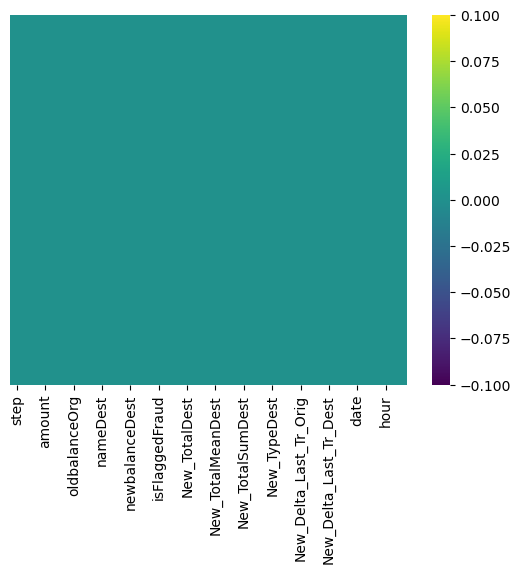

In [8]:
sns.heatmap(data_f.isnull(), yticklabels=False,cmap='viridis')

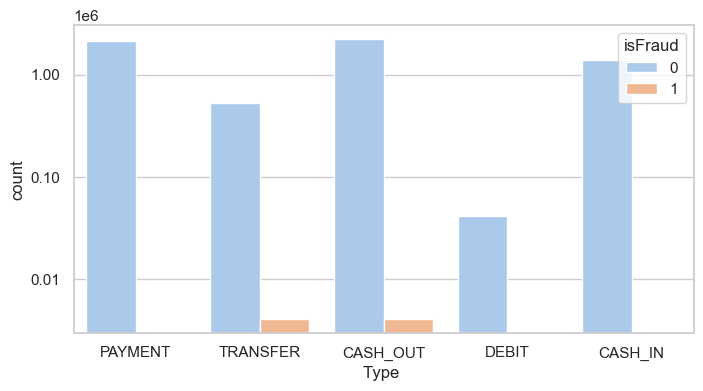

In [9]:
def countplot_eda(data_f):
    sns.set_style('whitegrid')
    sns.set_context('notebook')
    plt.figure(figsize=(8, 4))
    counplot = sns.countplot(data=data_f, x='type', hue='isFraud',palette= "pastel")
    counplot.set_xlabel('Type ')
    counplot.set_ylabel(f'count')
    counplot.set_yscale('log')
    counplot.yaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.show()

countplot_eda(data_f)

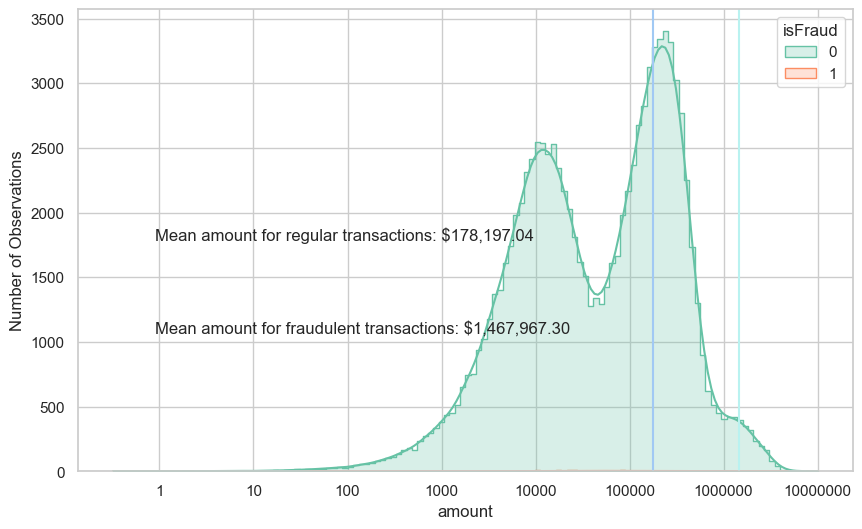

In [10]:
def histplot_eda(data):
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("pastel")
    histplot = sns.histplot(data=data[:100000], 
                            x='amount', 
                            hue='isFraud', 
                            kde=True, 
                            element='step', 
                            palette= "Set2", 
                            log_scale=True)
    histplot.set_ylabel('Number of Observations')
    histplot.set_xlabel(f'amount')
    mean_value_f = data[data['isFraud']==False]['amount'].mean()
    mean_value_t = data[data['isFraud']==True]['amount'].mean()
    histplot.axvline(x=mean_value_f, color=palette[0])
    histplot.axvline(x=mean_value_t, color=palette[-1])
    histplot.annotate(f'Mean amount for regular transactions: ${mean_value_f:,.2f}', 
                      xy=(0.1, 0.5),
                      xycoords='axes fraction')
    histplot.annotate(f'Mean amount for fraudulent transactions: ${mean_value_t:,.2f}', 
                      xy=(0.1, 0.3),
                      xycoords='axes fraction')
    histplot.xaxis.set_major_formatter(mticker.ScalarFormatter())
    histplot.ticklabel_format(style='plain', 
                              axis='x')  
    plt.show()
    
histplot_eda(data_f)

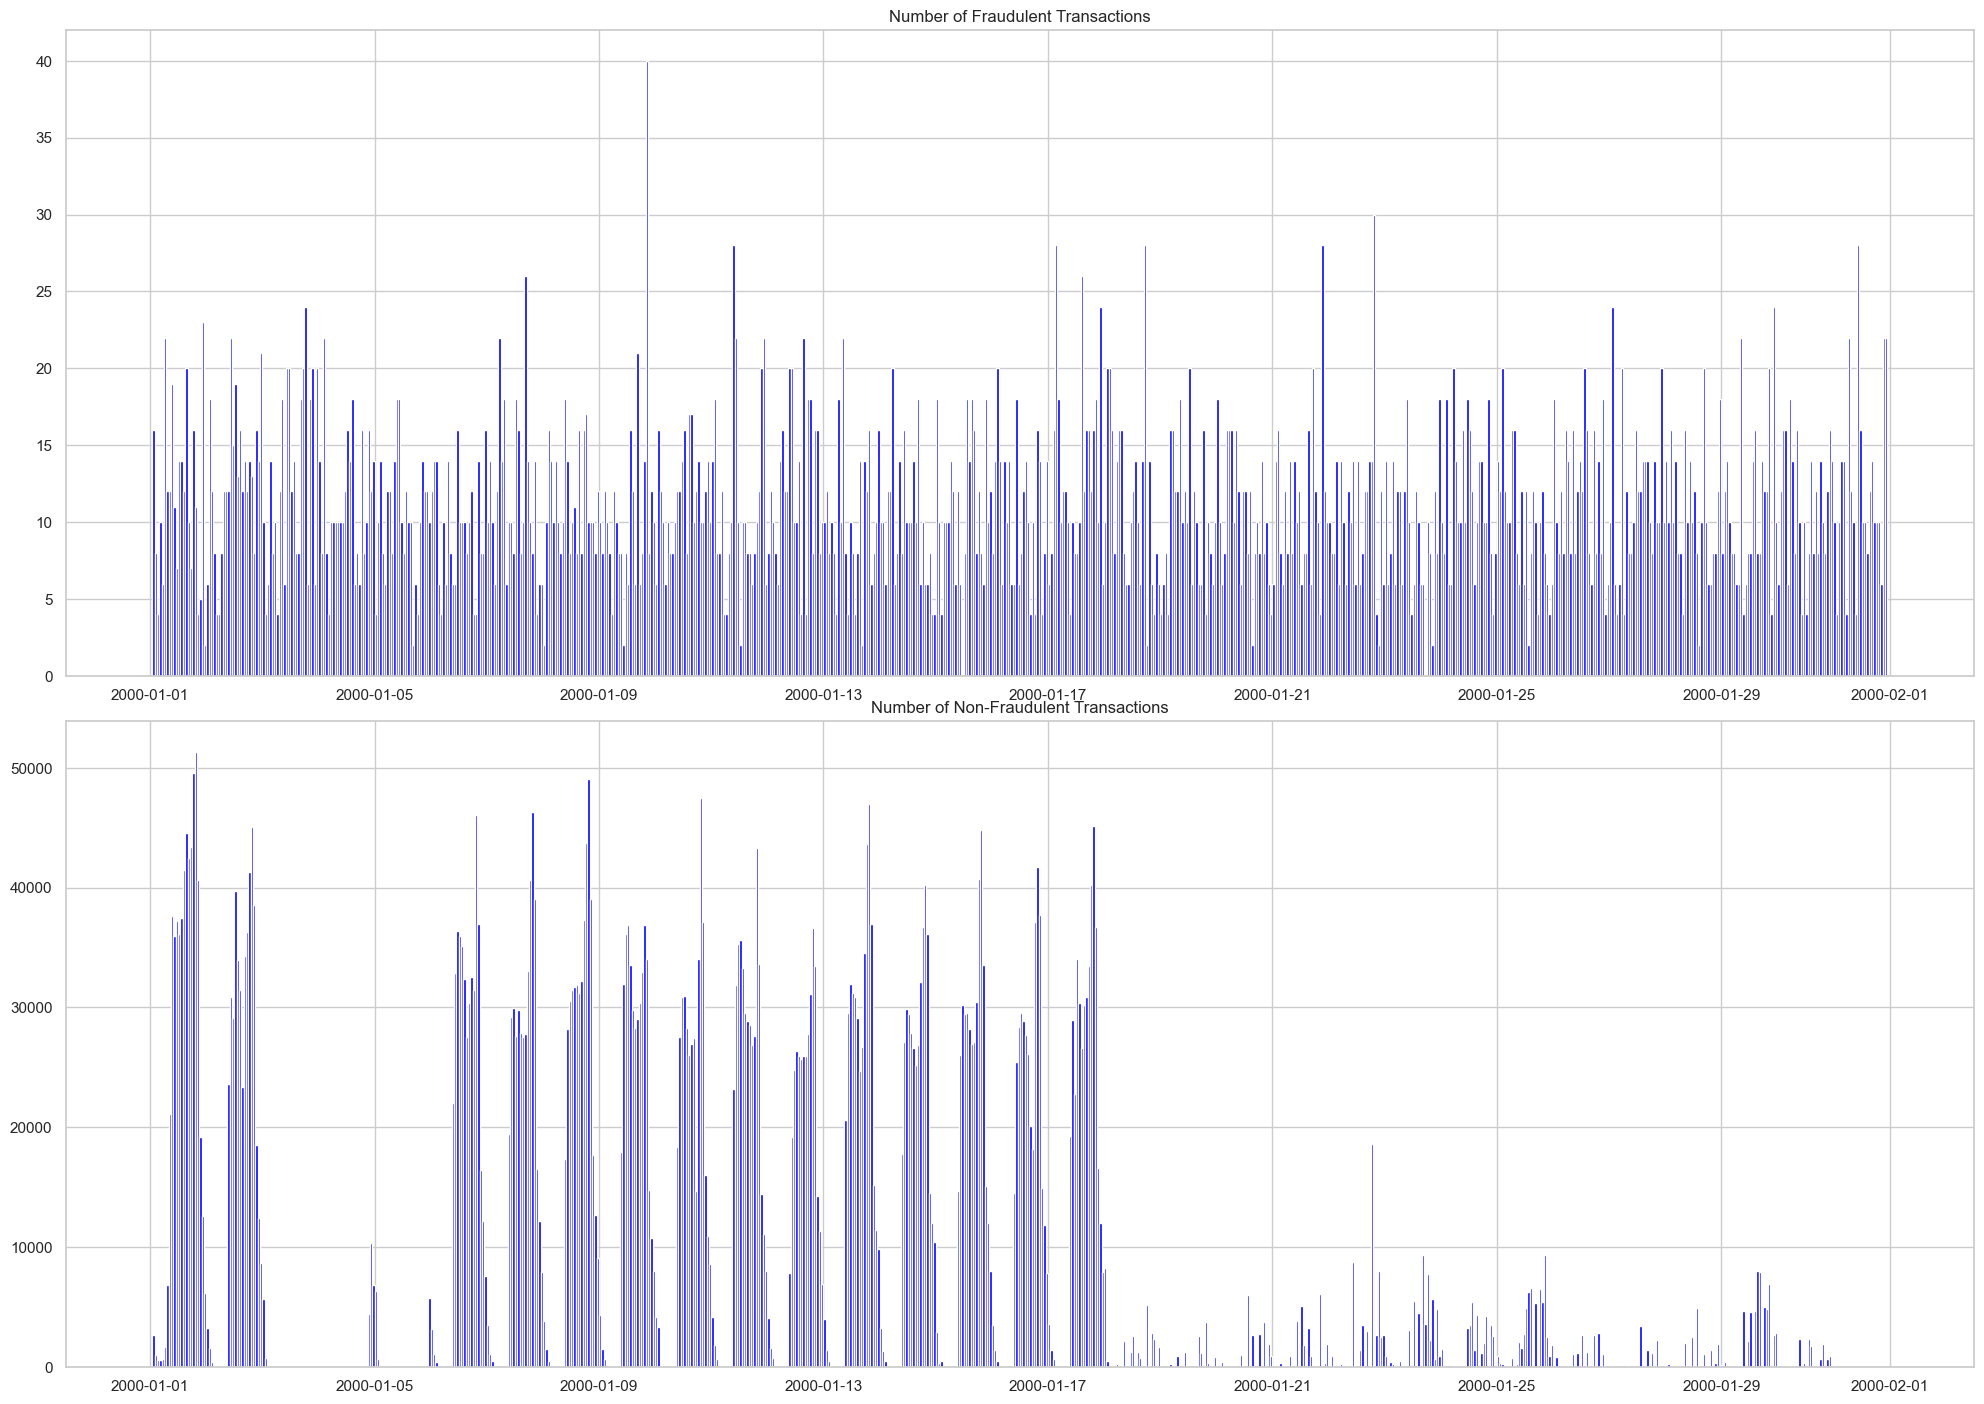

In [11]:
fig = plt.figure()
fig.set_size_inches(20, 14)
ax_1 = fig.add_subplot(2, 1, 1)
plt.hist(data_f[data_f['isFraud']==1]['res_data'], 
         bins=data_f['res_data'].unique(), 
         color = "blue")
ax_2 = fig.add_subplot(2, 1, 2)
plt.hist(data_f[data_f['isFraud']==0]['res_data'], 
         bins=data_f['res_data'].unique(),
         color = "blue")
fig.tight_layout()
ax_1.set(title = 'Number of Fraudulent Transactions')
ax_2.set(title = 'Number of Non-Fraudulent Transactions')
plt.show()

We can notice fraudulent transactions are distributed evenly over time, while regular transactions exhibit a certain pattern

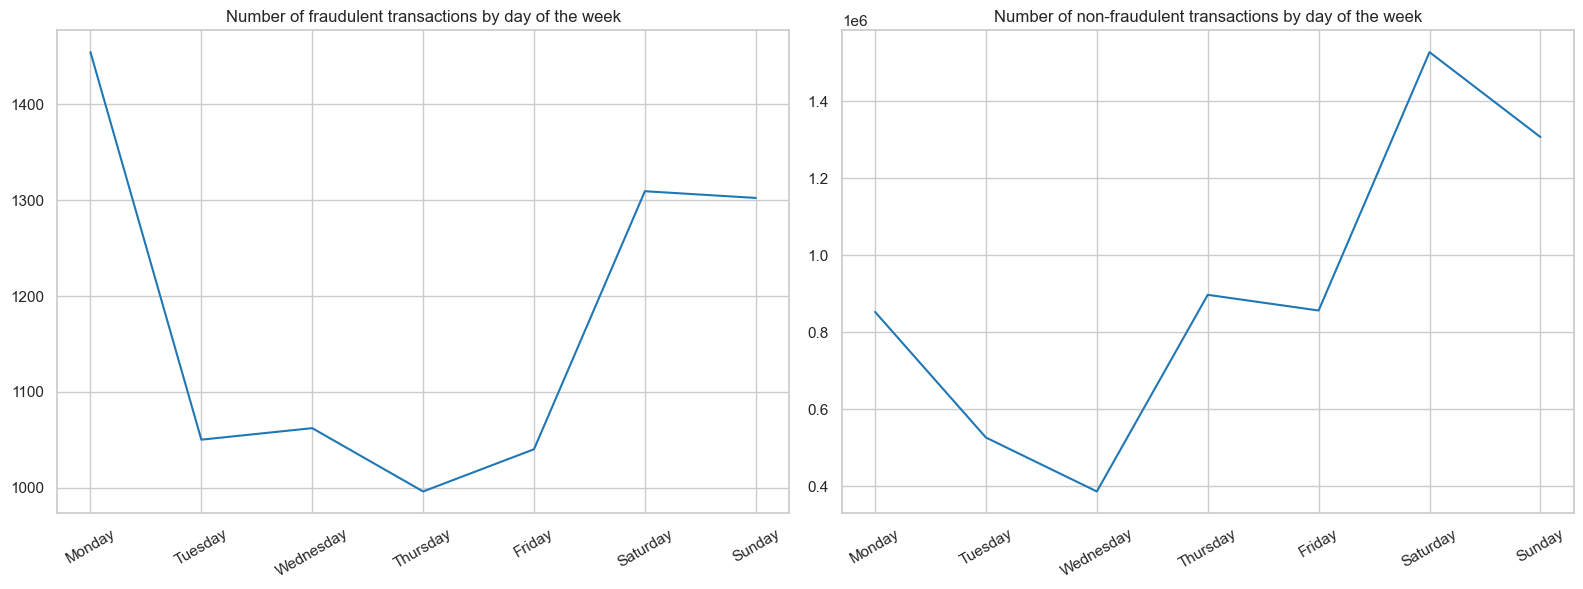

In [12]:
fig = plt.figure()
fig.set_size_inches(16, 6)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(data_f[data_f['isFraud']==1].groupby(['day_of_week']).size())
plt.xticks(range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
           rotation=30)

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(data_f[data_f['isFraud']==0].groupby(['day_of_week']).size())
plt.xticks(range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
           rotation=30)

fig.tight_layout()
ax_1.set(title = 'Number of fraudulent transactions by day of the week')
ax_2.set(title = 'Number of non-fraudulent transactions by day of the week')
plt.show()

We see the maximum number of fraudulent transactions on Monday and minimum number of fraudulent transactions on Thursday. 
We see the maximum number of non-fraudulent transactions on Saturday and minimum number of fraudulent transactions on Wednesday

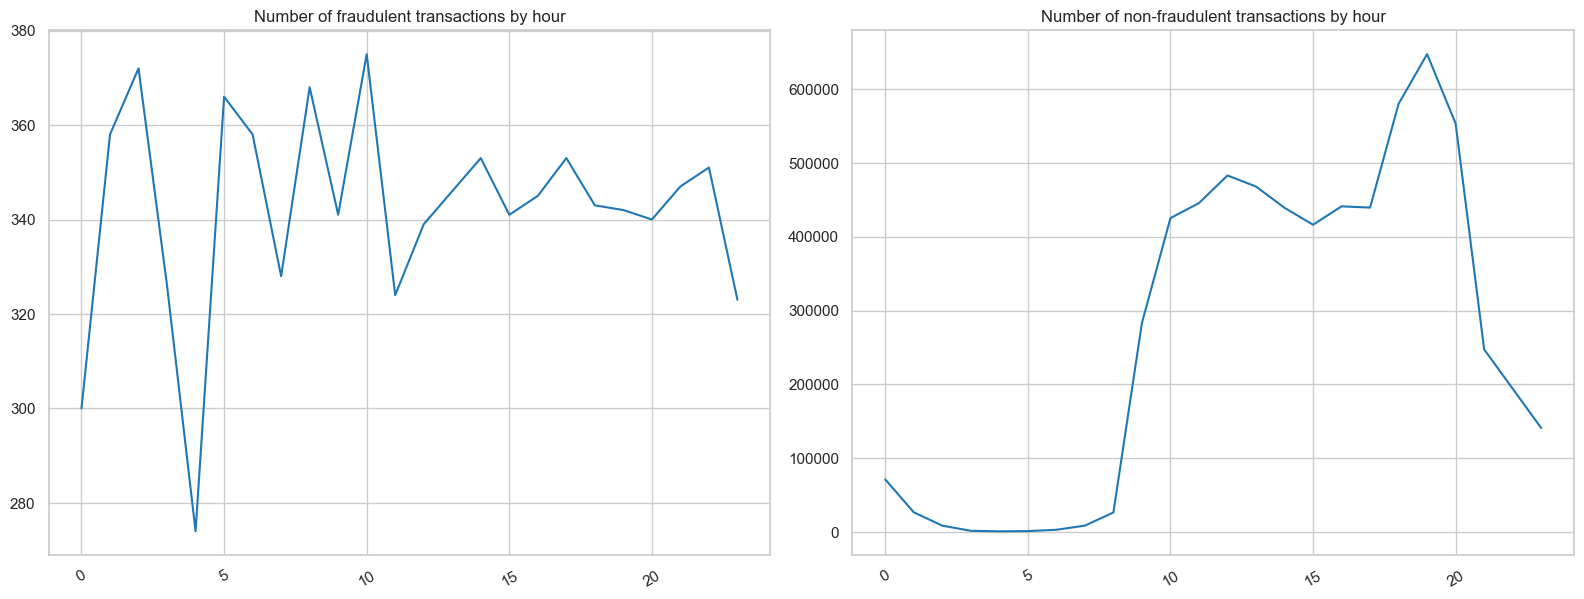

In [13]:
fig = plt.figure()
fig.set_size_inches(16, 6)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(data_f[data_f['isFraud']==1].groupby(['hour']).size())
plt.xticks(rotation=30)

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(data_f[data_f['isFraud']==0].groupby(['hour']).size())
plt.xticks(rotation=30)

fig.tight_layout()
ax_1.set(title = 'Number of fraudulent transactions by hour')
ax_2.set(title = 'Number of non-fraudulent transactions by hour')
plt.show()

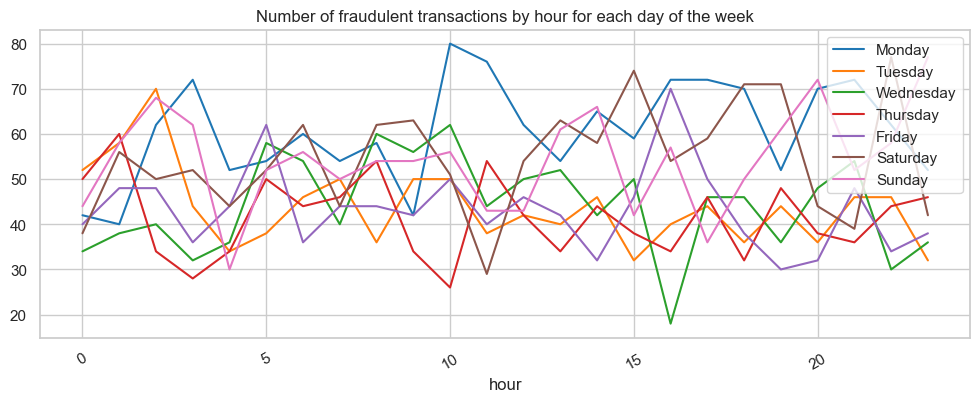

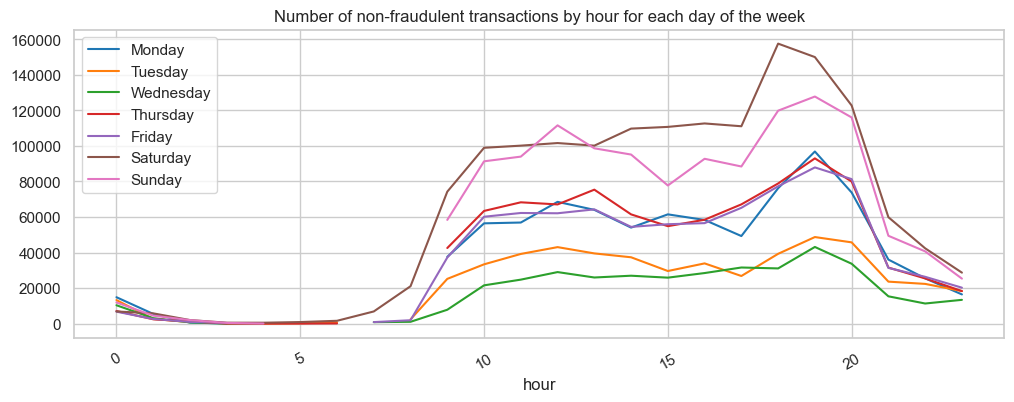

In [14]:
### Let's build average target curves by hours for each day of the week
frame1 = data_f[data_f['isFraud']==1].groupby(['day_of_week', 'hour'], as_index=False)['amount'].count()
frame1 = frame1.pivot(index='hour', columns='day_of_week', values='amount')
frame1.plot(figsize=(12, 4),color=['#1f77b4', '#ff7f0e', '#2ca02c', 
                                   '#d62728', '#9467bd','#8c564b', '#e377c2'])
plt.xticks(rotation=30)
plt.title('Number of fraudulent transactions by hour for each day of the week')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

frame2 = data_f[data_f['isFraud']==0].groupby(['day_of_week', 'hour'], as_index=False)['amount'].count()
frame2 = frame2.pivot(index='hour', columns='day_of_week', values='amount')
frame2.plot(figsize=(12, 4),color=['#1f77b4', '#ff7f0e', '#2ca02c', 
                                   '#d62728', '#9467bd','#8c564b', '#e377c2'])
plt.xticks(rotation=30)
plt.title('Number of non-fraudulent transactions by hour for each day of the week')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()

It can be seen that the peak almost always falls at the same time on almost any day of the week, around 17-20 hours.

# Preparation of the data 

In [15]:
data_test = data_f.copy()
data_test.drop(columns = ['step', 'nameOrig','nameDest', 'isFlaggedFraud', 
                          'New_TotalOrig', 'New_TotalDest', 'New_TotalMeanOrig',
                          'New_TotalMeanDest', 'New_TotalSumOrig', 'New_TotalSumDest', 
                          'New_Delta_Time_Tr_Orig','New_Delta_Last_Tr_Orig', 
                          'New_Delta_Time_Tr_Dest','New_Delta_Last_Tr_Dest', 
                          'res_data', 'date', 'day_of_week', 'hour','month'], 
               inplace=True)

In [16]:
data_test

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,New_TypeOrig,New_TypeDest
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,C,M
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,C,M
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,C,C
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,C,C
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,C,M
...,...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,C,C
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,C,C
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,C,C
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,C,C


In [17]:
print(data_test.dtypes)

type               object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
New_TypeOrig       object
New_TypeDest       object
dtype: object


In [18]:
#due to the fact that we have few unique values, we will go by the simple way of converting categorical features
data_test = pd.get_dummies(data_test, prefix = ['type', 'New_TypeOrig', 'New_TypeDest'], drop_first = True)

In [19]:
data_test

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,New_TypeDest_M
0,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,1,0,1
1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,1,0,1
2,181.00,181.00,0.00,0.00,0.00,1,0,0,0,1,0
3,181.00,181.00,0.00,21182.00,0.00,1,1,0,0,0,0
4,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13,1,1,0,0,0,0
6362616,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0,0,1,0
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,1,0,0,0,0
6362618,850002.52,850002.52,0.00,0.00,0.00,1,0,0,0,1,0


In [20]:
X = data_test.drop(columns=['isFraud'])
y = data_test['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
def metrics_estimation(model, X_train_sm, X_test, y_train_sm, y_test, prediction, prob):
    #We build all kinds of combinations precision, recall, threshold
    precision, recall, thres = precision_recall_curve(y_test, prob[:, 1])
    #We find a triple for which recall is maximum and precision > 0.6
    ind = np.where(recall == recall[precision > 0.6].max())
    print(f"Precison score:\t {precision[ind][-1]}")
    print(f"Recall score: \t {recall[ind][-1]}")
    print(f"Threshold:\t {thres[ind][-1]}")

    # calculate f1_score for binary classification problem
    f1 = f1_score(y_test, prediction, average='binary')
    print('F1 score: %f' % (f1))

    # retrieve the probabilities for the positive class
    prob_positive = prob[:, 1]

    ###Log Loss Score
    logloss = log_loss(y_test, prob)
    print('Log Loss score: %f' % (logloss))

    ###Brier Score
    brier = brier_score_loss(y_test, prob_positive)
    print('Brier score: %f' % (brier))
    
    return (precision[ind][-1], recall[ind][-1], f1, logloss, brier, thres[ind][-1])

# Logistic Regression

In [22]:
lr_model = LogisticRegression(random_state=42)

In [23]:
lr_model.fit(X_train,y_train)

LogisticRegression(random_state=42)

In [24]:
Train_score = lr_model.score(X_train,y_train)
print('Train_score: ',Train_score)

Train_score:  0.9992401453070171


In [25]:
Test_score = lr_model.score(X_test, y_test)
print('Test_Score: ',Test_score)

Test_Score:  0.9992374210623926


In [26]:
pred_train = lr_model.predict(X_train)
pred_test = lr_model.predict(X_test)

In [27]:
accuracy_logistics = accuracy_score(y_test,pred_test)

In [28]:
print(metrics.classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.90      0.46      0.61      2045

    accuracy                           1.00   1590655
   macro avg       0.95      0.73      0.80   1590655
weighted avg       1.00      1.00      1.00   1590655



In [29]:
lr_prediction=lr_model.predict(X_test)

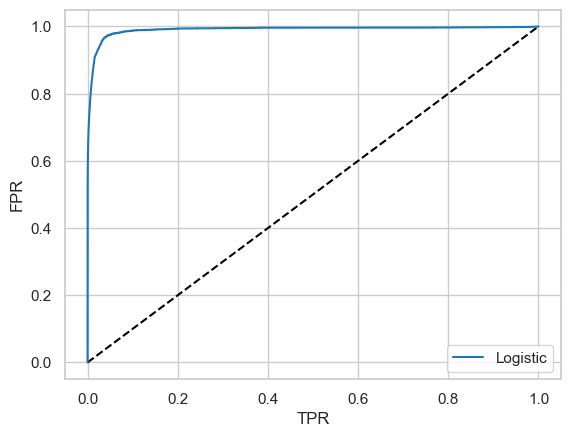

In [30]:
roc = lr_model.predict_proba(X_train)[:,1]

fpr,tpr,threshold = metrics.roc_curve(y_train, roc)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic')
plt.ylabel('FPR')
plt.xlabel('TPR')
plt.legend(loc='lower right')
plt.show()

In [31]:
metrics.roc_auc_score(y_train, roc)

0.9904232542257247

Confusion Matrix:  [[1588501     109]
 [   1104     941]]


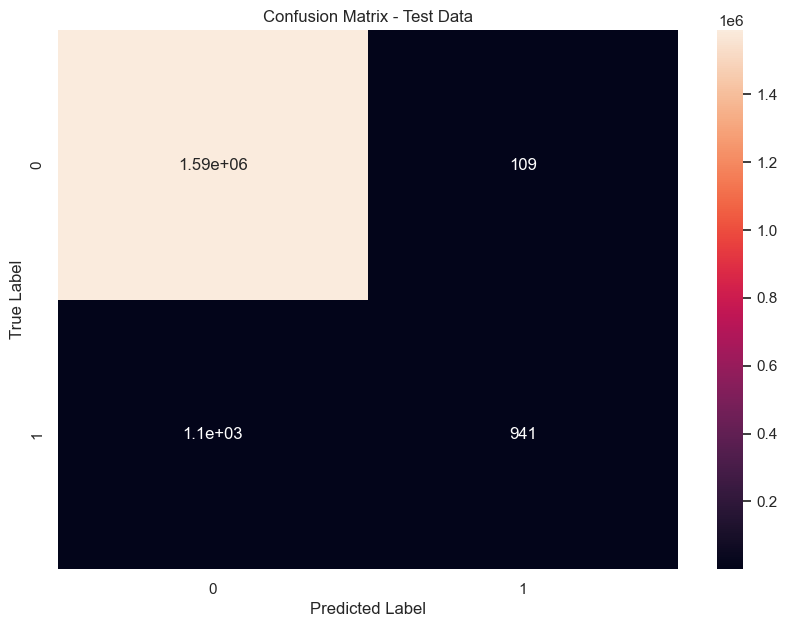

In [32]:
cm = confusion_matrix(y_test,pred_test)
print('Confusion Matrix: ',cm)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt = '.3g')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Tuning

# GridSearch CV

In [33]:
param_grid = {
    'penalty':['l1', 'l2'],
    'C' : [0.1, 0.5, 1, 5, 10]
}

In [34]:
grid = GridSearchCV(estimator = lr_model, param_grid=param_grid, cv = 5)

In [35]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 0.5, 1, 5, 10], 'penalty': ['l1', 'l2']})

In [36]:
best_param = grid.best_params_
best_model = grid.best_estimator_

In [37]:
print('Best hyperparameters: ',best_param)

Best hyperparameters:  {'C': 5, 'penalty': 'l2'}


In [38]:
y_pred = best_model.predict(X_test)

In [39]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.32      0.80      0.46      2045

    accuracy                           1.00   1590655
   macro avg       0.66      0.90      0.73   1590655
weighted avg       1.00      1.00      1.00   1590655



Confusion Matrix:  [[1585170    3440]
 [    409    1636]]


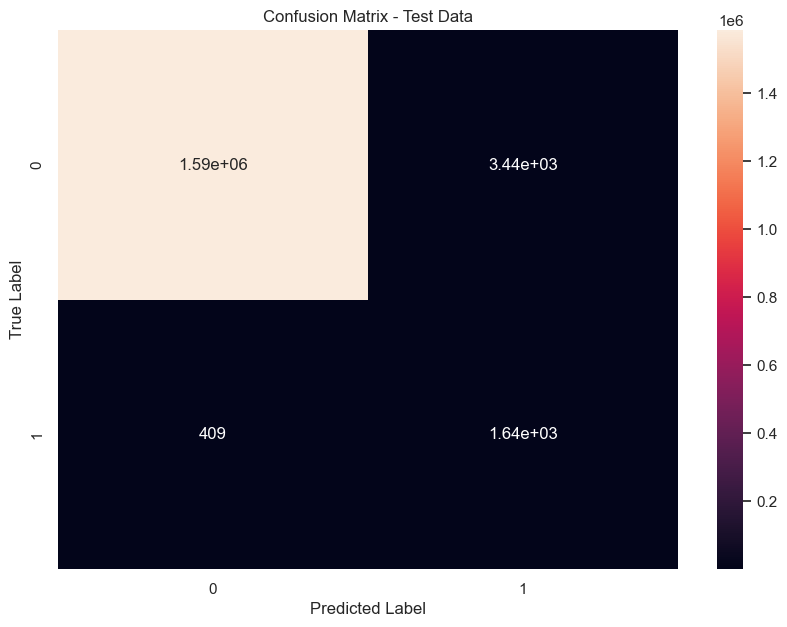

In [40]:
cm = confusion_matrix(y_test,y_pred)
print('Confusion Matrix: ',cm)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt = '.3g')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# RandomSearch CV

In [41]:
logistic_random_param={'C':loguniform(1e-4,1e0),
                      'max_iter':(np.arange(100,800,10))}
grid=RandomizedSearchCV(estimator=lr_model, param_distributions=logistic_random_param, cv=5)

In [42]:
grid.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15f003e10>,
                                        'max_iter': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
       620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
       750, 760, 770, 780, 790])})

In [43]:
best_param = grid.best_params_
best_model = grid.best_estimator_

In [44]:
print("Best Hyperparameters:", best_param)

Best Hyperparameters: {'C': 0.11554749428404647, 'max_iter': 470}


In [45]:
y_pred = best_model.predict(X_test)

In [46]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.32      0.80      0.46      2045

    accuracy                           1.00   1590655
   macro avg       0.66      0.90      0.73   1590655
weighted avg       1.00      1.00      1.00   1590655



Confusion Matrix:  [[1585170    3440]
 [    409    1636]]


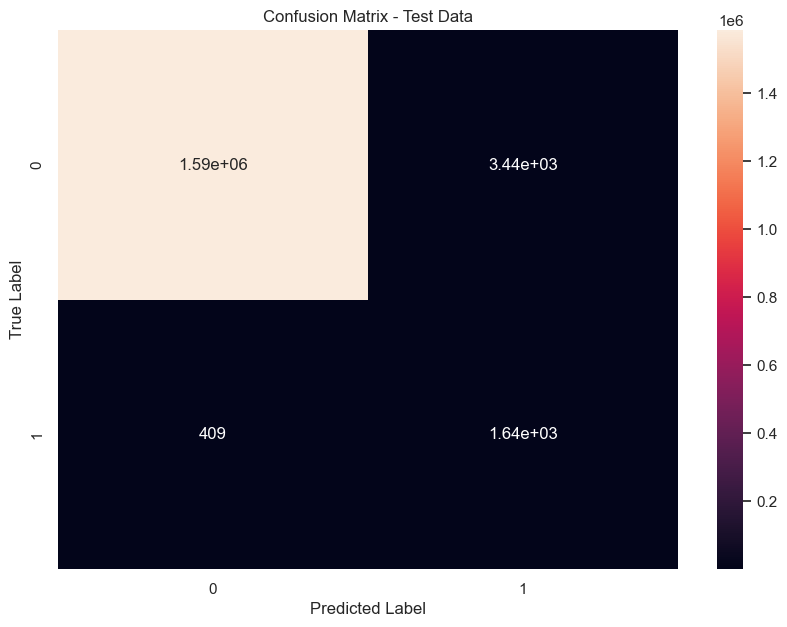

In [47]:
cm = confusion_matrix(y_test,y_pred)
print('Confusion Matrix: ',cm)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt = '.3g')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# kNN (k Nearest Neighbour)

In [48]:
scaler = StandardScaler()
Xsc_train = scaler.fit_transform(X_train)
Xsc_test = scaler.transform(X_test)

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [50]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(Xsc_train, y_train)
knn_prediction = knn_model.predict(Xsc_test)
knn_prob = knn_model.predict_proba(Xsc_test)

In [51]:
def metrics_estimation_for_knn(model, X_train_sm, X_test, y_train, y_test, prediction, prob):
    #We build all kinds of combinations precision, recall, threshold
    precision, recall, thres = precision_recall_curve(y_test, prob[:, 1])
    #We find a triple for which recall is maximum and precision > 0.6
    ind = np.where(recall == recall[precision > 0.6].max())
    print(f"Precison score:\t {precision[ind][-1]}")
    print(f"Recall score: \t {recall[ind][-1]}")

    # calculate f1_score for binary classification problem
    f1 = f1_score(y_test, prediction, average='binary')
    print('F1 score: %f' % (f1))


    
    return (precision[ind][-1], recall[ind][-1], f1)

list_metrics_knn = metrics_estimation_for_knn(knn_model, Xsc_train, Xsc_test, y_train, y_test, knn_prediction, knn_prob)

Precison score:	 0.8068582955118507
Recall score: 	 0.78239608801956
F1 score: 0.822699


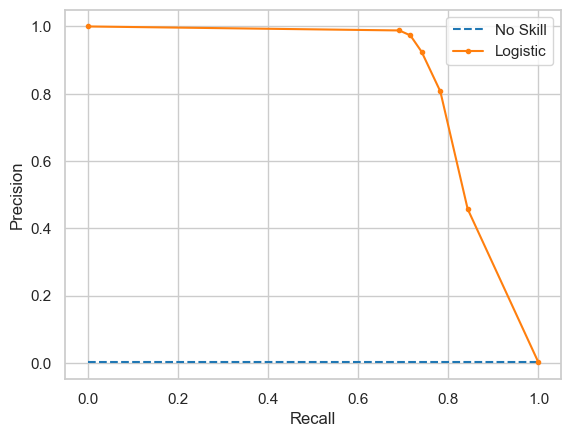

AUC PR: 0.845


In [52]:
# retrieve the probabilities for the positive class
knn_prob_positive = knn_prob[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = len((y_train[y_train==1])+(y_test[y_test==1])) / len(y_train + y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, knn_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)


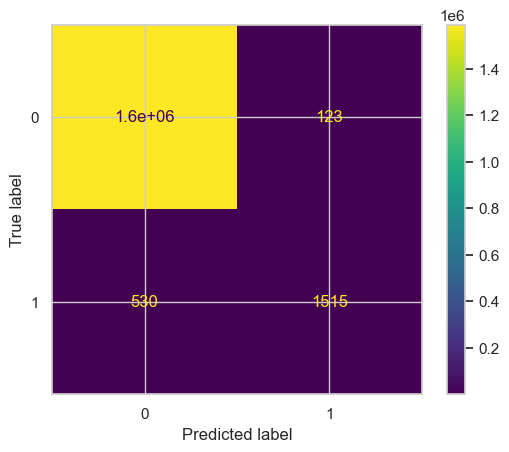

In [53]:
#confusion matrix
cm = confusion_matrix(y_test, knn_prediction, labels=knn_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot()
plt.show()

In [54]:
print(classification_report(knn_prediction, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1589017
           1       0.74      0.92      0.82      1638

    accuracy                           1.00   1590655
   macro avg       0.87      0.96      0.91   1590655
weighted avg       1.00      1.00      1.00   1590655



# Random Forest

In [78]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf_model.fit(Xsc_train, y_train)
rf_prediction = rf_model.predict(Xsc_test)
rf_prob = rf_model.predict_proba(Xsc_test)

In [79]:
list_metrics_rf = metrics_estimation(rf_model, Xsc_train, Xsc_test, y_train, y_test, rf_prediction, rf_prob)

Precison score:	 0.6837231968810916
Recall score: 	 0.6860635696821515
Threshold:	 0.027681528394530298
F1 score: 0.000000
Log Loss score: 0.005587
Brier score: 0.001072


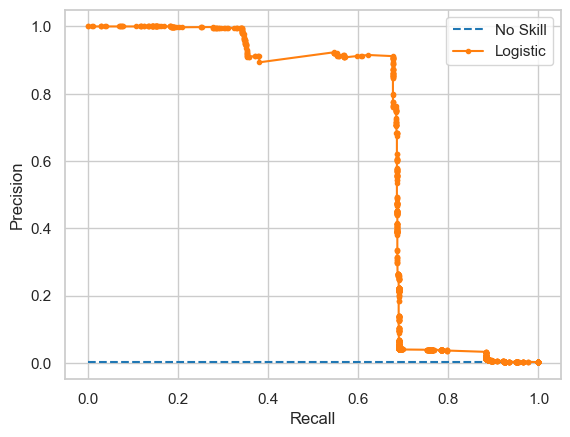

AUC PR: 0.663


In [80]:
# retrieve the probabilities for the positive class
rf_prob_positive = rf_prob[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = len((y_train[y_train==1])+(y_test[y_test==1])) / len(y_train + y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, rf_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

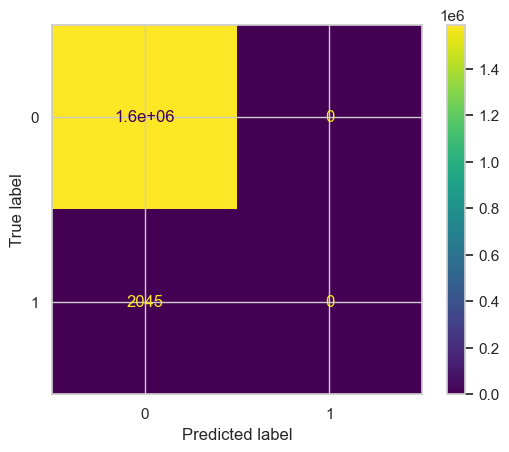

In [81]:
cm_rf = confusion_matrix(y_test, rf_prediction, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp.plot()
plt.show()

In [82]:
print(classification_report(rf_prediction, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1590655
           1       0.00      0.00      0.00         0

    accuracy                           1.00   1590655
   macro avg       0.50      0.50      0.50   1590655
weighted avg       1.00      1.00      1.00   1590655



# Decision Tree

In [98]:
dtc_model=DecisionTreeClassifier(random_state=42)
dtc_model.fit(Xsc_train,y_train)
dtc_prediction=dtc_model.predict(Xsc_test)
dtc_prob = dtc_model.predict_proba(Xsc_test)

In [99]:
list_metrics_dtc = metrics_estimation(dtc_model, Xsc_train, Xsc_test, y_train, y_test, dtc_prediction, dtc_prob)

Precison score:	 0.9056511056511056
Recall score: 	 0.9012224938875305
Threshold:	 1.0
F1 score: 0.903431
Log Loss score: 0.008928
Brier score: 0.000248


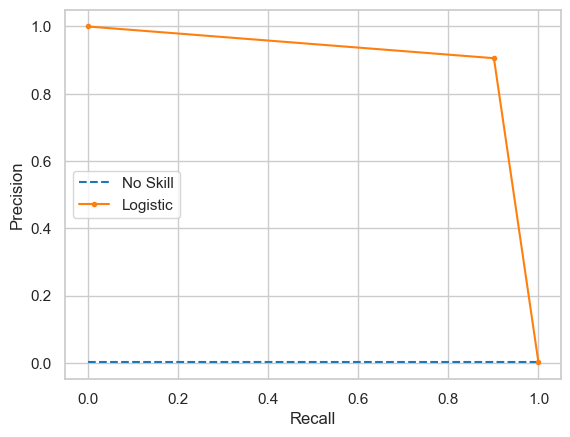

AUC PR: 0.904


In [100]:
# retrieve the probabilities for the positive class
dtc_prob_positive = dtc_prob[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = len((y_train[y_train==1])+(y_test[y_test==1])) / len(y_train + y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, dtc_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

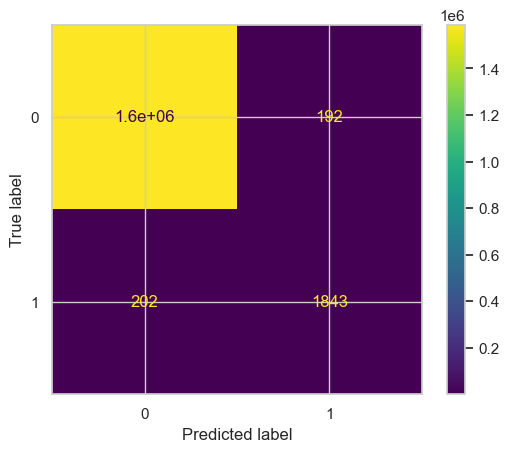

In [101]:
cm_dtc = confusion_matrix(y_test, dtc_prediction, labels=dtc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtc, display_labels=dtc_model.classes_)
disp.plot()
plt.show()

In [102]:
print(classification_report(dtc_prediction, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588620
           1       0.90      0.91      0.90      2035

    accuracy                           1.00   1590655
   macro avg       0.95      0.95      0.95   1590655
weighted avg       1.00      1.00      1.00   1590655

